## Question 4

#### a. Implementing random matrix multiplication

In [103]:
# Importing all required libraries
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(920211348) 

In [104]:
def randomized_matrix_mul(A,B, C = 100, sampling_type = 'non-uniform', r = -9999):
    """
    Summary: Function generates the randomized matrix multiplication depending 
    on the parametes passed.
    Args:
        A (np.matrix): Matrix A of dimensions m x n
        B (np.matrix): Matrix B of dimensions n x p
        C (int, optional): A constant used to determine sampling. Defaults to 100.
        sampling_type (str, optional): Decides the type of sampling ie. uniform or non uniform
                                     Defaults to 'non-uniform'.
    
    Returns:
        ans (np.matrix): Matrix C of dimensions m x p obtained by product of A and B
    """
    
    # Selecting n from the input matrices 
    n =A.shape[1]
    
    # Selecting a suitable r given by r = Clogn 
    # where n is the dimension of the matrix
    if r == -9999:
        r = int(np.round(C * np.log(n))) 
    
    # Checking for the sampling type
    if sampling_type == 'uniform': 
        # Probability of sampling is equal ie. 1/n 
        pk = [1/n] * n
    else:
        # Defined as pk = ||A||k ||B ||k / sum_i (||A||i ||B||i)
        total_norm = sum([np.linalg.norm(A[:,k], ord = 2) * np.linalg.norm(B[k,:], ord = 2) for k in range(n)])
        pk = [np.linalg.norm(A[:,k], ord = 2) * np.linalg.norm(B[k,:], ord = 2)/total_norm for k in range(n)]
    
    # getting a sample with the probability distribution pk
    index_range = np.random.choice(range(n),r, replace = True, p = pk)

    # Getting the product of all chosen rank-1 matrices 
    ans = sum((1/(pk[k] * r)) * np.outer(A[:,k], B[k,:]) for k in index_range)
    return ans

#### b. Loading the matrices from the given files and applying it for the given r

In [105]:
# Loading A and B from the CSV files
A = np.matrix(np.loadtxt('STA243_homework_1_matrix_A.csv', delimiter = ','))
B = np.matrix(np.loadtxt('STA243_homework_1_matrix_B.csv', delimiter = ','))

In [106]:
def mul_error(approximate, actual,A,B):
    """Summary: Function to calculate the error between the approximate and actual matrices
    using the Frobenius norm

    Args:
        approximate (np.matrix): The randomized matrix multiplication output
        actual (np.matrix): The actual matrix multiplication output

    Returns:
        _type_: float
    """
    return np.linalg.norm(approximate - actual, ord = 'fro')/((np.linalg.norm(A, ord = 'fro') * np.linalg.norm(B, ord = 'fro')))

#### c. Calculate approximation error of the matrix multiplication

In [107]:
# Calling the functions required

# Checking for various columns mentioned in the question 
r = [20,50,100,200]

errors = []
actual = A @ B 
# Non-uniform sampling
for col_val in r:
    approximate = randomized_matrix_mul(A,B,r = col_val, sampling_type = 'non-uniform')
    e = mul_error(approximate, actual,A,B)
    errors.append(e)

# importing the required libraries
from texttable import Texttable
import latextable
table = Texttable()

# Creating a table for displaying the values
table.set_cols_dtype(['f', 'f'])

x = [['Rank', 'Error']] + [[r[i], errors[i]] for i in range(len(errors))]
table.add_rows(x)
print(table.draw())
print(latextable.draw_latex(table, caption = "R vs Error obtained"))


+---------+-------+
|  Rank   | Error |
+=========+=======+
| 20.000  | 0.207 |
+---------+-------+
| 50.000  | 0.116 |
+---------+-------+
| 100.000 | 0.097 |
+---------+-------+
| 200.000 | 0.075 |
+---------+-------+
\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|}
			\hline
			Rank & Error \\
			\hline
			20.000 & 0.207 \\
			\hline
			50.000 & 0.116 \\
			\hline
			100.000 & 0.097 \\
			\hline
			200.000 & 0.075 \\
			\hline
		\end{tabular}
	\end{center}
	\caption{R vs Error obtained}
\end{table}


#### d. Visualizing the errors obtained for different r values

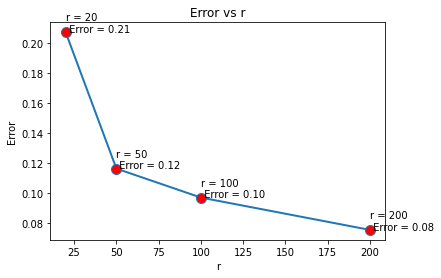

In [108]:
# Visualizing the errors obtained from the random multiplication
plt.plot(r, errors, ls = '-', lw = 2, marker = 'o',
         markersize = 10,
         markerfacecolor = 'red', label = 'Non-uniform sampling')
plt.xlabel('r')
plt.ylabel('Error')
plt.title('Error vs r')
for i in range(len(r)):
    plt.annotate("r = {} \n Error = {:.2f}".format(r[i],errors[i]), (r[i], errors[i]))
    

# Question 5
Implementing Power method for calculating eigenvalues and eigenvectors of a square matrix

In [109]:
def power_iteration(A, v0, eps = 1e-6, maxiter=100):
    """
    Summary: 
    Function to implement the power iteration algorithm to find the eigenvector of the matrix A
    Args:
        A: np.array (d, d) = Matrix A for which the eigenvector is to be found
        v0: np.array (d,) = unit vector to be used as the initial vector
        eps: float  = Error tolerance
        maxiter: int = Maximum number of iterations
    
    Returns:
        v: np.array (d,) = Eigenvector of A
    """
    for _ in range(maxiter):
        # Calculating the dot product of the matrix A and the current vector
        v = A @ v0
        # Normalizing the vector
        v = v/np.linalg.norm(v,2)
        # Checking for the convergence
        if np.linalg.norm(v - v0, 2) < eps:
            return v
        # Updating the current vector
        v0 = v
        
    return v

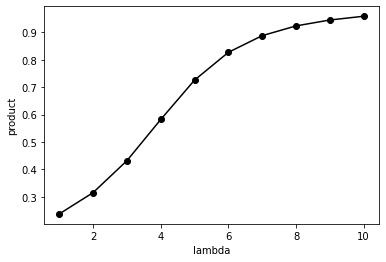

In [110]:
# Implementing the driver code given in the power_sim.py file 
np.random.seed(2022)
E = np.random.normal(size=(10,10))
v = np.array([1]+[0]*9)
lams = np.arange(1, 11)
prods = []
for lam in lams:
    X = lam*np.outer(v,v) + E
    v0 = np.ones(10)
    v0 = v0/np.linalg.norm(v0,2)
    vv = power_iteration(X, v0)
    prods.append(np.abs(v @ vv))

plt.plot(lams, prods, '-ok')
plt.xlabel('lambda')
plt.ylabel('product')
plt.show()




# Question 6
Implementing the sketched OLS

In [111]:
import scipy as sp
import scipy.sparse
import sympy.discrete as sym
from numba import jit
import time

In [119]:
# Improving the speed of execution by using numba
@jit(nopython=True)
def sketchify(D):
    """Summary:
    For a given matrix runs all the necessary information and returns the sketch matrix

    Args:
        D (np.matrix): matrix to be transformed
    
    Returns:
        D: Applies a FHWT transform on the given matrix
    """
    # Implementing the Fast Walsh Hadamard Transform (From Wikipedia)
    def fwht(a):
        """In-place Fast Walsh–Hadamard Transform of array a."""
        h = 1
        while h < len(a):
            for i in range(0, len(a), h * 2):
                for j in range(i, i + h):
                    x = a[j]
                    y = a[j + h]
                    a[j] = x + y
                    a[j + h] = x - y
            h *= 2
        return a
    
    # Getting n 
    n = D.shape[0]
    
    # Getting the sketch matrix
    return fwht(D)/np.sqrt(n)
    

def sketched_ols(X,y,eps):
    """Summary: 
    Function to implement the sketched OLS method

    Args:
        X ( np.matrix): Covariates for the given data
        y (np.matrix): Response vector
        eps (float): Error term used in determing 'r' columns to be sampled
    
    Returns:
        beta (np.matrix): Estimated coefficients
        time (float): endTime - startTime : Time taken to run the algorithm
    """
    
    # Checking for the dimensions of the input matrices
    if X.shape[0] != y.shape[0]:
        raise ValueError('X and y must have the same number of rows')
    
    np.random.seed(920211348)
    # Assigning n  & d 
    n = X.shape[0]
    d = X.shape[1]
    
    r = int(d * np.log(n)/eps)
    
    # Getting the S matrix 
    s = []
    
    # columnar constant 
    k = np.sqrt(n/r)
    
    row = []
    col = []
    data = []
    # Generating the subsample matrix S
    for iter in range(r):
        i = np.random.randint(1,n)
        row.append(i)
        col.append(iter)
        
        data.append(k)  
    
    # Using the sparse matrix to generate the S matrix and avoid memory errors    
    S = sp.sparse.csc_matrix((data,(row,col)), shape = (n,r))
    
    # Creating the diagonal matrix D
    D = np.random.choice([-1,1], size = (n,), replace = True).reshape(n,1)
    
    # Sketch of X
    sx = sketchify(D*X)
    
    # Sketch of y
    sy = sketchify(D*y)
    
    # Divinding the final multiplication into 2 steps
    # Start time for a given eps 
    startTime = time.time()
    component_1 = S.T @ sx
    component_2 = S.T @ sy

    # Calculating the final matrix ie. the estimates
    bs = np.linalg.inv(component_1.T @ component_1) @ component_1.T @ component_2
    
    # End time for a given eps
    endTime = time.time()
    
    # Returning the final estimates and the time taken
    return (bs,(endTime-startTime))


In [120]:
# Constant defined in the problem 
z = 2**20

np.random.seed(920211348)
# getting X and y matrix 
X = np.random.uniform(size = (z,20))
y = np.random.uniform(size = (z,1)) 

# Apply the sketched OLS method for all given errors
eps = [0.1,0.05,0.01,0.001]
estimated_betas = {}
computation_times = [0] * len(eps)
i = 0
for e in eps:
    estimated_betas[str(e)],computation_times[i] = sketched_ols(X,y,e)
    i += 1

In [121]:
startTime = time.time()

computing_actual_betas = np.linalg.inv(X.T @ X) @ X.T @ y
endTime = time.time()

actual_time = endTime - startTime

In [122]:
actual_time

0.19479012489318848

In [123]:
computation_times

[0.0032143592834472656,
 0.004021644592285156,
 0.012020349502563477,
 0.07588529586791992]

In [130]:
computing_actual_betas

array([[0.04881089],
       [0.04959641],
       [0.04726143],
       [0.05008491],
       [0.05099625],
       [0.05036854],
       [0.05094788],
       [0.04840546],
       [0.04933937],
       [0.04828794],
       [0.04805272],
       [0.04739559],
       [0.04843776],
       [0.05146802],
       [0.04955615],
       [0.05071392],
       [0.04756059],
       [0.04726957],
       [0.04868768],
       [0.05031452]])

In [134]:
errors = {}
for e,b in estimated_betas.items():
    errors[str(e)] = np.linalg.norm(b - computing_actual_betas,2) ** 2

In [135]:
table_2 = Texttable()

table_2.set_cols_dtype(['f', 'f','f','t'])

x = [['Epsilon', 'Error ||estimate - actual||2','Computation Times','% Improvement']] + [
    [e,error,t,"{:.3f}%".format((actual_time-t)/t * 100)] for (e,error),t in zip(errors.items(),computation_times)]
table_2.add_rows(x)
print(table_2.draw())
print(latextable.draw_latex(table_2, caption = "Epsilon vs Error obtained"))

+---------+------------------------------+-------------------+---------------+
| Epsilon | Error ||estimate - actual||2 | Computation Times | % Improvement |
+=========+==============================+===================+===============+
| 0.100   | 0.149                        | 0.003             | 5959.999%     |
+---------+------------------------------+-------------------+---------------+
| 0.050   | 0.062                        | 0.004             | 4743.544%     |
+---------+------------------------------+-------------------+---------------+
| 0.010   | 0.059                        | 0.012             | 1520.503%     |
+---------+------------------------------+-------------------+---------------+
| 0.001   | 0.101                        | 0.076             | 156.690%      |
+---------+------------------------------+-------------------+---------------+
\begin{table}
	\begin{center}
		\begin{tabular}{|l|l|l|l|}
			\hline
			Epsilon & Error ||estimate - actual||2 & Computation Times 